<a href="https://colab.research.google.com/github/twyeh/solid-state-physics/blob/main/%E6%99%B6%E6%A0%BC%E7%B5%90%E6%A7%8B%E8%88%87%E8%83%BD%E5%B8%B6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

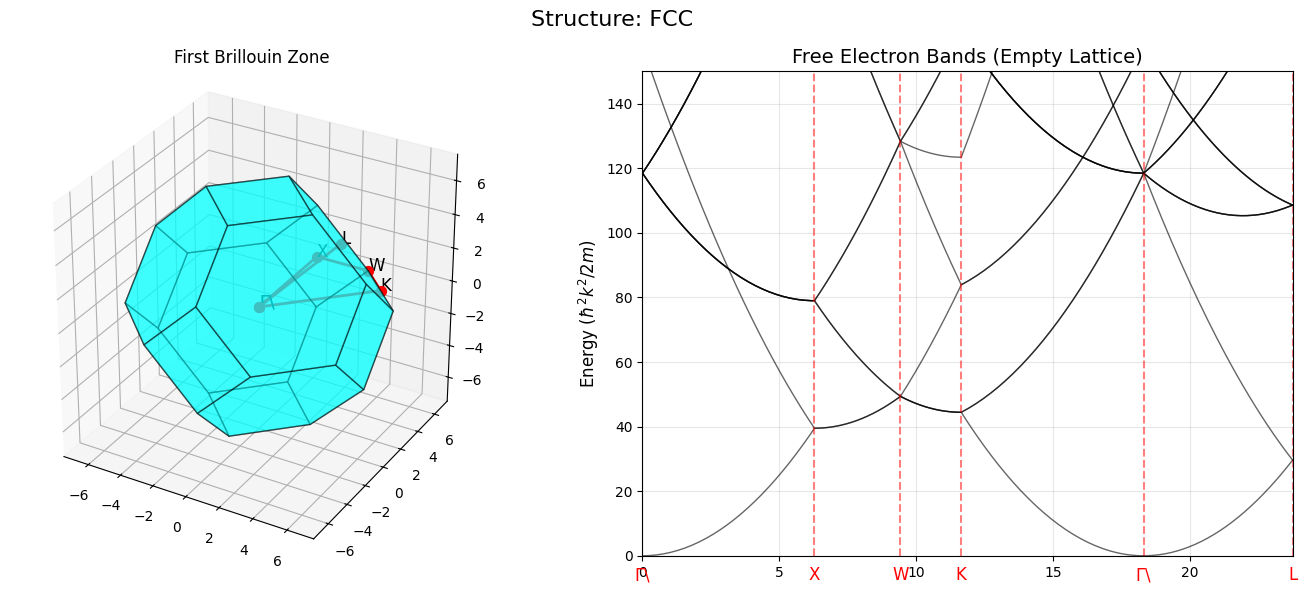

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import Voronoi

def get_lattice_vectors(structure='sc', a=1.0):
    """
    回傳實空間晶格向量 (a1, a2, a3)
    """
    if structure == 'sc':
        # Simple Cubic
        return np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) * a
    elif structure == 'fcc':
        # Face Centered Cubic
        return np.array([[0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]]) * a
    elif structure == 'bcc':
        # Body Centered Cubic
        return np.array([[-0.5, 0.5, 0.5], [0.5, -0.5, 0.5], [0.5, 0.5, -0.5]]) * a
    return None

def get_reciprocal_vectors(a_vecs):
    """
    計算倒格向量 b1, b2, b3
    b_i = 2 * np.pi * (a_j x a_k) / (a_i . (a_j x a_k))
    """
    a1, a2, a3 = a_vecs
    vol = np.dot(a1, np.cross(a2, a3))
    b1 = 2 * np.pi * np.cross(a2, a3) / vol
    b2 = 2 * np.pi * np.cross(a3, a1) / vol
    b3 = 2 * np.pi * np.cross(a1, a2) / vol
    return np.array([b1, b2, b3])

def get_high_sym_path(structure, b_vecs):
    """
    定義高對稱點路徑 (Standard paths)
    """
    b1, b2, b3 = b_vecs
    path_points = {}
    path_labels = []

    # 定義高對稱點 (以倒格向量為基底或笛卡爾坐標)
    # 注意：這裡使用標準定義，需根據具體 b_vecs 調整

    if structure == 'sc':
        # SC Reciprocal is SC. Gamma(0,0,0), X(0.5,0,0)*2pi/a, M(0.5,0.5,0), R(0.5,0.5,0.5)
        # 假設 b_vecs 是標準軸向 (2pi/a)
        # b1=[2pi,0,0], ...
        G = np.array([0, 0, 0])
        X = 0.5 * b1
        M = 0.5 * b1 + 0.5 * b2
        R = 0.5 * b1 + 0.5 * b2 + 0.5 * b3

        points = [G, X, M, G, R, X]
        labels = [r'$\%s$\%s' % ('Gamma', ''), 'X', 'M', r'$\%s$\%s' % ('Gamma', ''), 'R', 'X']

    elif structure == 'fcc':
        # FCC Reciprocal is BCC.
        # Standard path: Gamma - X - W - K - Gamma - L
        # b1, b2, b3 define the BCC reciprocal lattice
        # 需要根據倒格基底線性組合出高對稱點
        # 這裡直接使用笛卡爾坐標的通用定義 (假設 a=1 => 倒空間尺度)
        # b_vecs[0] = (-1, 1, 1) * 2pi/a (for standard FCC) if using the primitive definition above

        # 為了通用性，我們使用傳統笛卡爾坐標定義高對稱點位置，然後縮放
        k0 = 2 * np.pi # scale factor

        G = np.array([0, 0, 0])
        X = np.array([0, 1, 0]) * k0 # [0, 2pi/a, 0]
        # L = (0.5, 0.5, 0.5) * 2pi/a is center of hexagonal face
        L = np.array([0.5, 0.5, 0.5]) * k0
        # W = (0.5, 1, 0)
        W = np.array([0.5, 1, 0]) * k0
        # K = (0.75, 0.75, 0)
        K = np.array([0.75, 0.75, 0]) * k0

        points = [G, X, W, K, G, L]
        labels = [r'$\%s$\%s' % ('Gamma', ''), 'X', 'W', 'K', r'$\%s$\%s' % ('Gamma', ''), 'L']

    elif structure == 'bcc':
        # BCC Reciprocal is FCC.
        # Standard path: Gamma - H - N - Gamma - P - H
        k0 = 2 * np.pi

        G = np.array([0, 0, 0])
        H = np.array([0, 0, 1]) * k0 # 邊角 (like X in SC but further)
        N = np.array([0, 0.5, 0.5]) * k0 # 面心
        P = np.array([0.25, 0.25, 0.25]) * k0 # 四面體頂點

        points = [G, H, N, G, P, H]
        labels = [r'$\%s$\%s' % ('Gamma', ''), 'H', 'N', r'$\%s$\%s' % ('Gamma', ''), 'P', 'H']

    return points, labels

def get_g_vectors(b_vecs, n_max=2):
    """
    生成倒格向量 G = n1*b1 + n2*b2 + n3*b3
    用於將拋物線折疊回第一 BZ
    """
    n_range = range(-n_max, n_max + 1)
    g_vecs = []
    for n1 in n_range:
        for n2 in n_range:
            for n3 in n_range:
                g = n1 * b_vecs[0] + n2 * b_vecs[1] + n3 * b_vecs[2]
                g_vecs.append(g)
    return np.array(g_vecs)

def plot_brillouin_zone_and_bands(structure_type):
    # 1. 設定晶格
    a = 1.0
    a_vecs = get_lattice_vectors(structure_type, a)
    b_vecs = get_reciprocal_vectors(a_vecs)

    # 2. 計算 Voronoi (Brillouin Zone)
    # 為了得到完整的 BZ，我們需要生成原點周圍足夠多的倒格點
    g_for_voronoi = get_g_vectors(b_vecs, n_max=1)
    # Voronoi 需要足夠的鄰居來封閉原點的 cell
    vor = Voronoi(g_for_voronoi)

    # 3. 準備能帶路徑
    sym_points, sym_labels = get_high_sym_path(structure_type, b_vecs)

    # 生成路徑上的 k 點
    k_path_segments = []
    k_plot_x_values = []
    k_node_indices = [0] # The first symmetry point is at distance 0

    current_cumulative_distance = 0.0

    num_points_per_segment = 50

    for i in range(len(sym_points) - 1):
        start_point = sym_points[i]
        end_point = sym_points[i+1]
        segment_length = np.linalg.norm(end_point - start_point)

        # Generate k-vectors for this segment
        segment_k_points_full = np.linspace(start_point, end_point, num_points_per_segment)

        # Generate distance values for this segment
        segment_relative_distances_full = np.linspace(0, segment_length, num_points_per_segment)

        if i == 0:
            # For the first segment, use all points
            k_path_segments.append(segment_k_points_full)
            k_plot_x_values.extend(segment_relative_distances_full)
        else:
            # For subsequent segments, exclude the first point to avoid duplication
            k_path_segments.append(segment_k_points_full[1:])
            k_plot_x_values.extend(current_cumulative_distance + segment_relative_distances_full[1:])

        current_cumulative_distance += segment_length

        # The high-symmetry points (except the first one) are at the end of each segment.
        # Their index in the k_plot_x_values list is `len(k_plot_x_values) - 1`.
        k_node_indices.append(len(k_plot_x_values) - 1)

    k_vecs = np.vstack(k_path_segments)
    k_plot_x = np.array(k_plot_x_values)

    # 4. 計算自由電子能帶 E = (hbar^2/2m) * |k + G|^2
    # 這裡我們使用單位: hbar^2/2m = 1, a = 1
    # 為了顯示清楚，我們選取較多 G 向量，但只畫能量較低的部分
    g_vecs_bands = get_g_vectors(b_vecs, n_max=2)

    energies = []
    for g in g_vecs_bands:
        # |k + G|^2
        e_band = np.linalg.norm(k_vecs + g, axis=1)**2
        energies.append(e_band)

    energies = np.array(energies)

    # --- 繪圖 ---
    fig = plt.figure(figsize=(14, 6))
    fig.suptitle(f'Structure: {structure_type.upper()}', fontsize=16)

    # Plot 1: Brillouin Zone (3D)
    ax1 = fig.add_subplot(121, projection='3d')

    # 繪製 BZ 面
    # 找出包含原點 (index 0 in g_for_voronoi) 的 region
    point_index = 0 # 原點是第一個生成的點 (0,0,0) 因為 range 順序通常如此，或是要搜尋
    # 更安全的做法是找最接近 0 的點的 index，通常是 0,0,0 對應的
    center_idx = np.argmin(np.linalg.norm(g_for_voronoi, axis=1))
    region_idx = vor.point_region[center_idx]
    region = vor.regions[region_idx]

    if -1 not in region and len(region) > 0:
        vertices = vor.vertices[region]
        # 為了正確繪製多面體，需要計算凸包或正確排序面
        # 這裡利用 scipy Voronoi 的 ridge_points 屬性來找面比較簡單

        faces = []
        for p1, p2 in vor.ridge_points:
            if p1 == center_idx or p2 == center_idx:
                # 這個 ridge 分隔了原點和另一個點，其對應的 ridge_vertices 就是一個面
                rid = vor.ridge_dict[(p1, p2)]
                if -1 not in rid:
                    faces.append(vor.vertices[rid])

        poly = Poly3DCollection(faces, alpha=0.5, edgecolor='k', linewidth=1)
        poly.set_facecolor('cyan')
        ax1.add_collection3d(poly)

        # 繪製高對稱路徑
        path_arr = np.array(sym_points)
        ax1.plot(path_arr[:,0], path_arr[:,1], path_arr[:,2], 'r-', linewidth=2, label='k-path')

        # 標記高對稱點
        for pt, lbl in zip(sym_points, sym_labels):
            ax1.scatter(pt[0], pt[1], pt[2], color='red', s=50)
            ax1.text(pt[0], pt[1], pt[2], lbl, fontsize=12)

        # 設定範圍
        limit = np.max(np.abs(vertices)) * 1.2
        ax1.set_xlim(-limit, limit)
        ax1.set_ylim(-limit, limit)
        ax1.set_zlim(-limit, limit)
        ax1.set_title("First Brillouin Zone")
        ax1.set_aspect('equal')

    # Plot 2: Band Structure
    ax2 = fig.add_subplot(122)

    # 設定能量顯示上限
    y_limit = 2.5 * (2*np.pi)**2 # 經驗值，大約顯示幾個帶
    if structure_type == 'fcc': y_limit = 150
    elif structure_type == 'bcc': y_limit = 150
    else: y_limit = 100

    # 繪製所有 bands
    for energy in energies:
        # 過濾掉太高的能量以加快繪圖 (非必要，matplotlib 處理線條很快)
        if np.min(energy) < y_limit:
            ax2.plot(k_plot_x, energy, 'k-', alpha=0.6, linewidth=1)

    # 繪製垂直線與標籤
    for idx, lbl in zip(k_node_indices, sym_labels):
        ax2.axvline(x=k_plot_x[idx], color='r', linestyle='--', alpha=0.5)
        ax2.text(k_plot_x[idx], -0.05 * y_limit, lbl, ha='center', fontsize=12, color='red')

    ax2.set_ylim(0, y_limit)
    ax2.set_xlim(0, k_plot_x[-1])
    ax2.set_ylabel(r'Energy ($\hbar^2 k^2 / 2m$)', fontsize=12)
    ax2.set_title("Free Electron Bands (Empty Lattice)", fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- 主程式：請修改此處變數來切換不同晶格 ---
# 選項: 'sc', 'fcc', 'bcc'
current_structure = 'fcc'
plot_brillouin_zone_and_bands(current_structure)